In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
#! /usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import gc

import numpy as np
import torch
import torch.backends.cudnn as cudnn
from torch import nn

from dataloader import cifar10
from models import VGG11
from src import freeze_influence, hessians, selection
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def load_net(net, path):
    assert os.path.isfile(path), "Error: no checkpoint file found!"
    checkpoint = torch.load(path)
    net.load_state_dict(checkpoint["net"])
    return net


def save_net(net, path):
    dir, filename = os.path.split(path)
    if not os.path.isdir(dir):
        os.makedirs(dir)

    state = {
        "net": net.state_dict(),
    }
    torch.save(state, path)


def test(net, dataloader, criterion, label):
    net.eval()
    with torch.no_grad():
        num_prediction_list = np.zeros(10)
        for _, (inputs, targets) in enumerate(dataloader):
            idx = targets == label
            inputs, targets = inputs[idx], targets[idx]
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)

            _, predicted = outputs.max(1)
            num_prediction_list = num_prediction_list + predicted.bincount(minlength=10).detach().cpu().numpy()

        return num_prediction_list

In [4]:
if device == "cuda":
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()

# Data
print("==> Preparing data..")
batch_size = 512
num_workers = 4
num_sample_batch = 1

data_loader = cifar10.CIFAR10DataLoader(batch_size, num_workers, validation=False)
train_loader, test_loader = data_loader.get_data_loaders()

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [5]:
num_label = 10

hist_list = []
for target_removal_label in range(num_label):
    print(target_removal_label)
    
    net_name = "VGG11"
    net_path = f"checkpoints/tab2/{net_name}/cross_entropy/ckpt_0.0.pth"
    net = VGG11().to(device)
    net = load_net(net, net_path)

    if_name = "GIF"
    param_ratio = 0.1
    net_path = (
        f"checkpoints/tab2/{net_name}/{if_name}/{target_removal_label}_{param_ratio}_{0}.pth"
    )
    net_GIF_10 = VGG11().to(device)
    net_GIF_10 = load_net(net_GIF_10, net_path)

    param_ratio = 0.3
    net_path = (
        f"checkpoints/tab2/{net_name}/{if_name}/{target_removal_label}_{param_ratio}_{0}.pth"
    )
    net_GIF_30 = VGG11().to(device)
    net_GIF_30 = load_net(net_GIF_30, net_path)

    param_ratio = 0.5
    net_path = (
        f"checkpoints/tab2/{net_name}/{if_name}/{target_removal_label}_{param_ratio}_{0}.pth"
    )
    net_GIF_50 = VGG11().to(device)
    net_GIF_50 = load_net(net_GIF_50, net_path)

    net_path = f"checkpoints/tab2/{net_name}_retrained/cross_entropy/ckpt_0.0_{target_removal_label}.pth"
    net_retrained = VGG11().to(device)
    net_retrained = load_net(net_retrained, net_path)

    net_list = [net, net_GIF_10, net_GIF_30, net_GIF_50, net_retrained]
    label_hist_list = []
    for net in net_list:
        num_prediction_list = test(net, test_loader, criterion, target_removal_label)
        print(
            f"Trained net: {num_prediction_list}"
        )
        label_hist_list.append(num_prediction_list)
    hist_list.append(label_hist_list)

0
Trained net: [919.   5.  22.   7.   7.   2.   3.   4.  23.   8.]
Trained net: [ 11.  24. 194.  98.  57.  10.  31.   6. 513.  56.]
Trained net: [  8.  24. 214. 122.  88.   9.  34.   5. 448.  48.]
Trained net: [ 12.   0. 523. 159. 111.   7.  52.   2. 103.  31.]
Trained net: [  0.  35. 336.  81.  48.   5.  20.  29. 304. 142.]
1
Trained net: [  3. 969.   0.   0.   1.   0.   1.   0.   2.  24.]
Trained net: [  7.   3.   0.   0.   0.   1.   0.   0.  30. 959.]
Trained net: [ 10.  16.   0.   1.   0.   1.   1.   0.  55. 916.]
Trained net: [  6.  15.   0.   0.   0.   2.   2.   0.  58. 917.]
Trained net: [ 38.   0.   5.  12.   0.   4.  12.   2. 113. 814.]
2
Trained net: [ 21.   0. 878.  25.  23.  19.  21.   6.   4.   3.]
Trained net: [103.   7.   2. 202. 259. 181. 211.  19.   3.  13.]
Trained net: [ 75.   7.   5. 303. 175. 216. 169.  23.   7.  20.]
Trained net: [ 81.   8.   3. 295. 169. 183. 213.  22.   7.  19.]
Trained net: [194.   5.   0. 192. 207. 149. 172.  52.  18.  11.]
3
Trained net: [  8

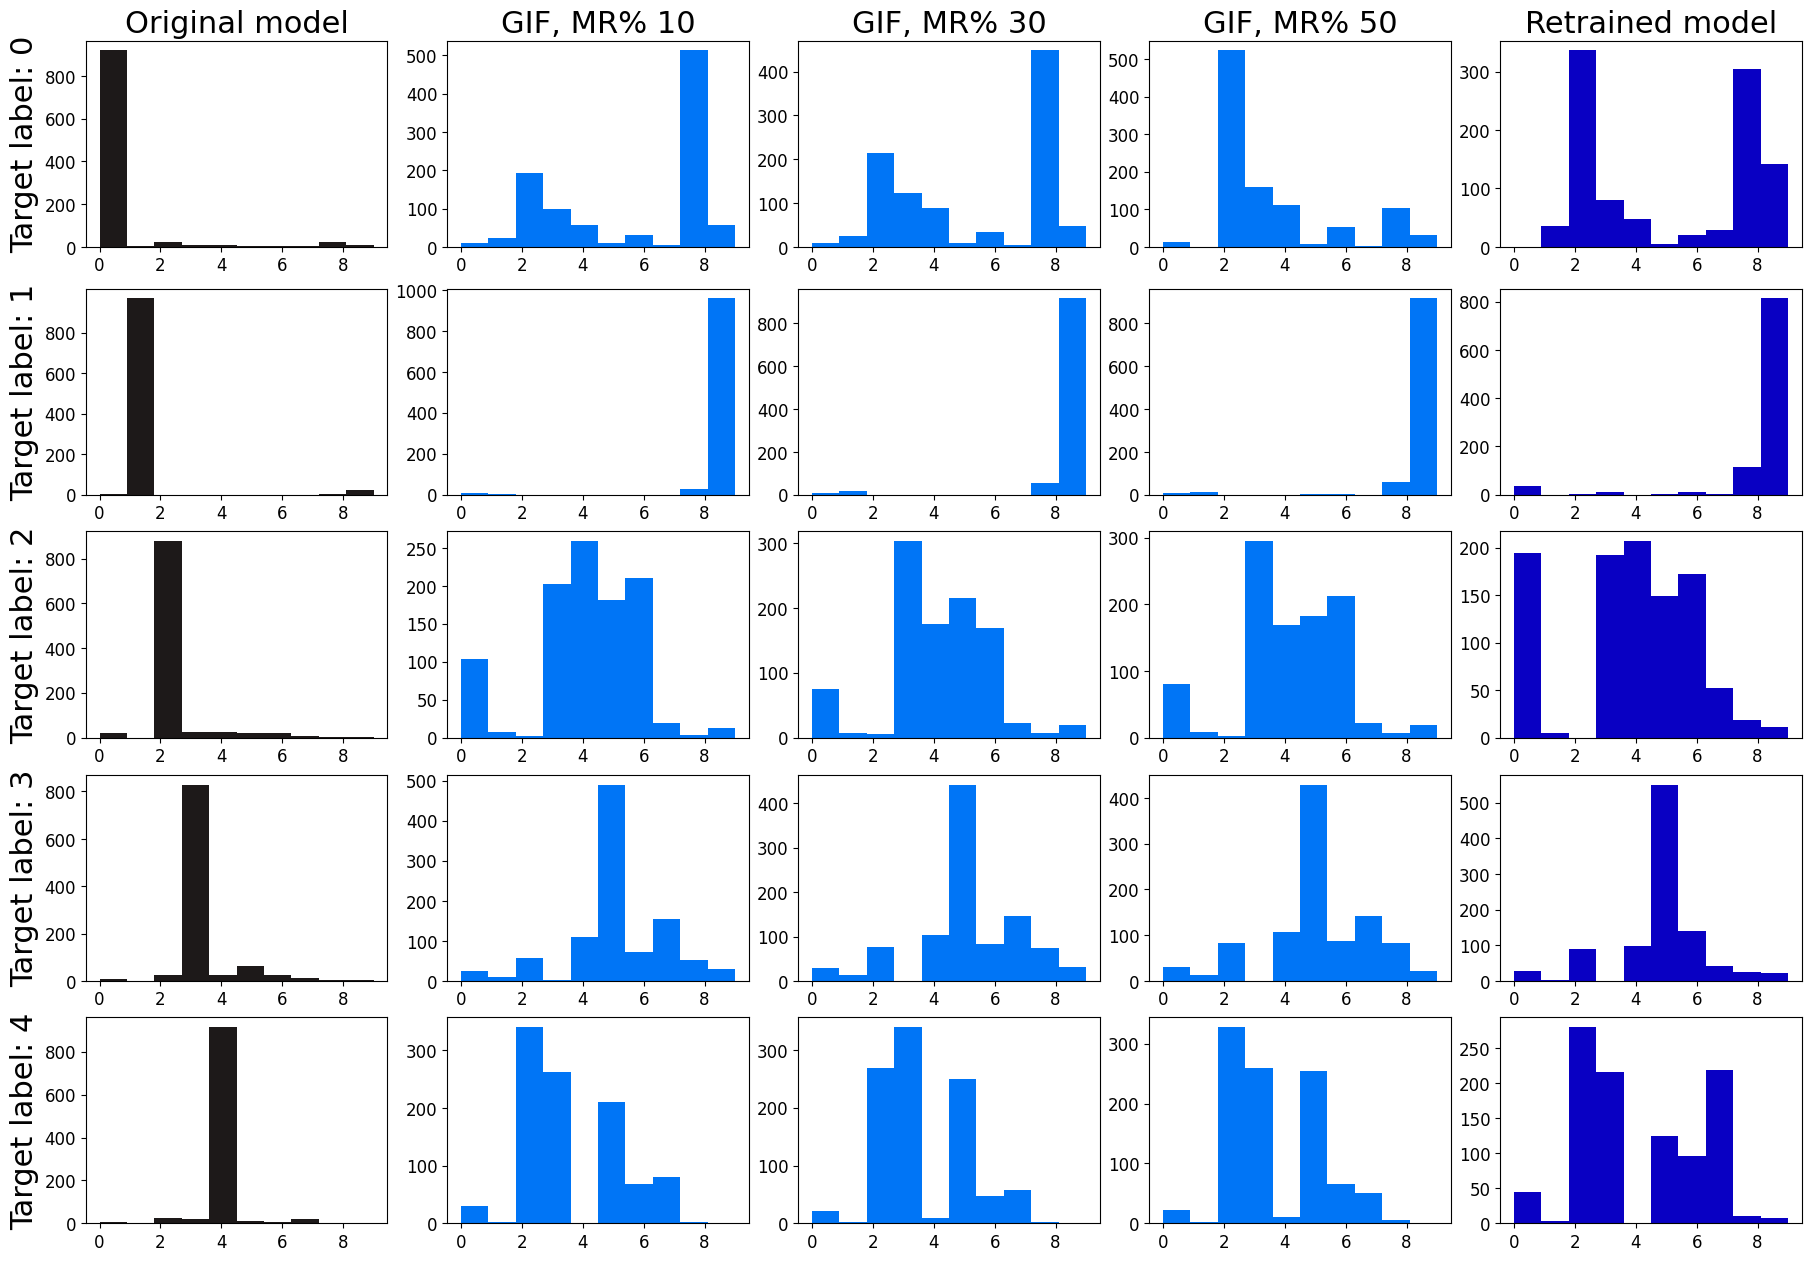

In [6]:
fig, axs = plt.subplots(5, 5, figsize=(18, 2.5 * 5), layout="constrained")
axs[0, 0].set_title("Original model", fontsize=22)
axs[0, 1].set_title("GIF, MR% 10", fontsize=22)
axs[0, 2].set_title("GIF, MR% 30", fontsize=22)
axs[0, 3].set_title("GIF, MR% 50", fontsize=22)
axs[0, 4].set_title("Retrained model", fontsize=22)

axs[1, 0].set_yticks([0,200,400,600,800])

for i in range(5):
    for j in range(5):
        axs[i, j].tick_params(axis='x', labelsize=12)
        axs[i, j].tick_params(axis='y', labelsize=12)

for label in range(5):   
    axs[label, 0].set_ylabel(f"Target label: {label}", fontsize=22)
    for i, (ax, hist) in enumerate(zip(axs[label], hist_list[label])):
        if i == 0:
            ax.hist(np.arange(10), 10, weights=hist, color="#1D1919")
        elif i == 4:
            ax.hist(np.arange(10), 10, weights=hist, color="#0900C3")
        else:
            ax.hist(np.arange(10), 10, weights=hist, color="#0075F6"   
)
        
plt.savefig('inference_histogram_0_4.eps',
            format='eps', 
            bbox_inches='tight', 
            transparent=True, 
            pad_inches=0)

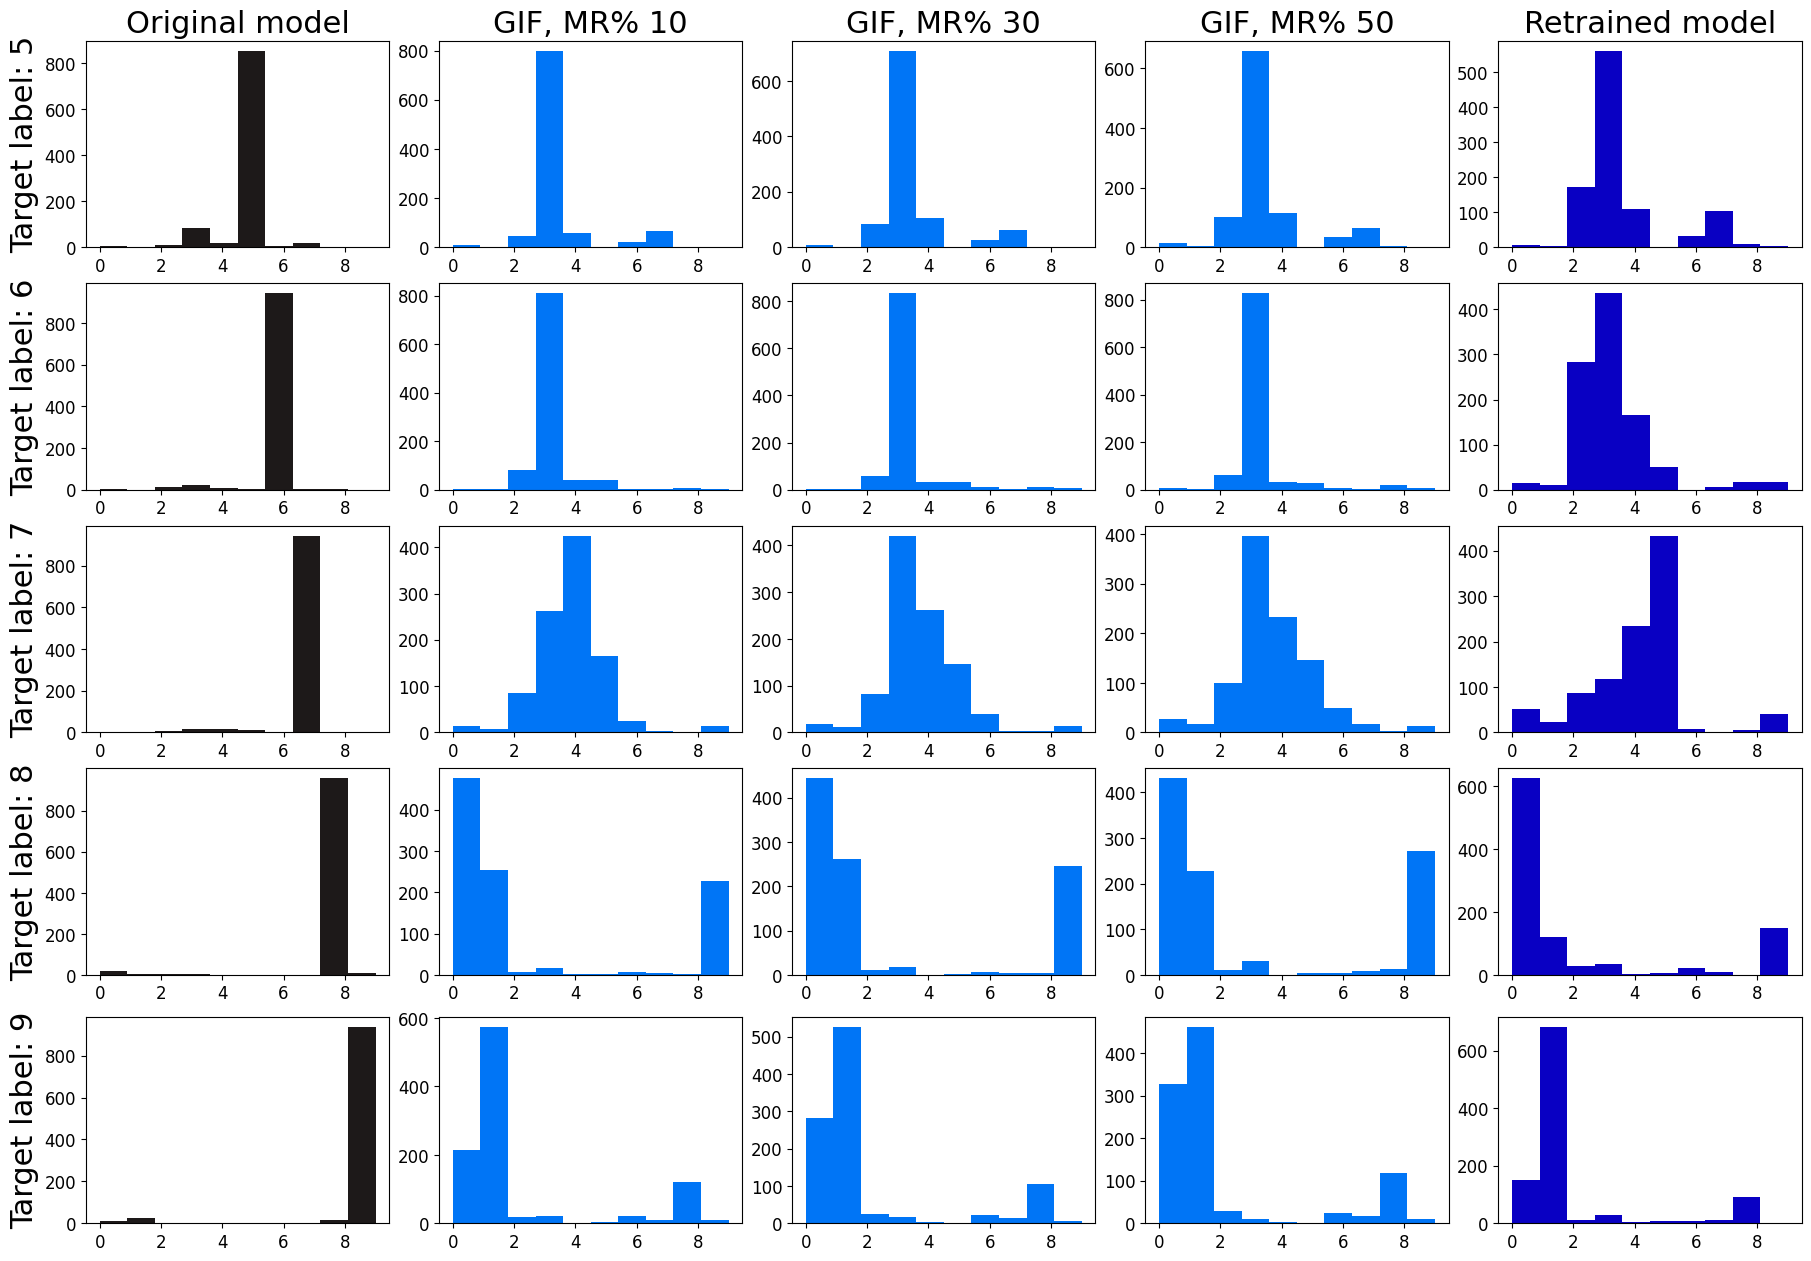

In [7]:
fig, axs = plt.subplots(5, 5, figsize=(18, 2.5 * 5), layout="constrained")
axs[0, 0].set_title("Original model", fontsize=22)
axs[0, 1].set_title("GIF, MR% 10", fontsize=22)
axs[0, 2].set_title("GIF, MR% 30", fontsize=22)
axs[0, 3].set_title("GIF, MR% 50", fontsize=22)
axs[0, 4].set_title("Retrained model", fontsize=22)

axs[3, 0].set_yticks([0,200,400,600,800])

for i in range(5):
    for j in range(5):
        axs[i, j].tick_params(axis='x', labelsize=12)
        axs[i, j].tick_params(axis='y', labelsize=12)

for label in range(5, 10):   
    axs[label-5, 0].set_ylabel(f"Target label: {label}", fontsize=22)
    for i, (ax, hist) in enumerate(zip(axs[label-5], hist_list[label])):
        if i == 0:
            ax.hist(np.arange(10), 10, weights=hist, color="#1D1919")
        elif i == 4:
            ax.hist(np.arange(10), 10, weights=hist, color="#0900C3")
        else:
            ax.hist(np.arange(10), 10, weights=hist, color="#0075F6"   
)
        
plt.savefig('inference_histogram_5_9.eps', 
            format='eps', 
            bbox_inches='tight', 
            transparent=True, 
            pad_inches=0)